# Spring harmonic motion

For this exam, we were asked to work with the classical simple harmonic problem of a spring (More at [Wikipedia](https://en.wikipedia.org/wiki/Simple_harmonic_motion)).

We were considering the problem were an object is attached to the end of a spring modelled by Hooke's Law

$F_{\text{spring}} = -kx$,

also affected by friction, modelled by a linear friction coefficient $b$, and a external sinusoidal force of amplitude $A$ and angular speed $\omega$, giving a total force of

$F = -kx -b*v + A*\sin(\omega t)$.

## Comparison to original code

This document will present my solutions to the tasks given.
Each extract of code has a reference to the file it refers.
Minor modifications have been performed to the code.
When this are irrelevant (like a change in the name of a variable with respect to what was sent), I won't mention it.

## The formulation

To group the problem's parameters, I cretaed a special structure called `SpringProblem`. Some parameters have a default value to allow to instantiate simple problems without friction or an external force.

In [1]:
# File: /src/Spring.jl
# -----------------------------------------------------------------------------------------

# Definitions -----------------------------------------------------------------------------

# We take the reference system to be the position of the spring in rest.
# That is, for the one dimensional case: (l, 0).

"""
    SpringProblem
    
Contains the parameters associated with a typical spring problem.

# Fields
- `t0`: Initial time of the problem (defaults to 0)
- `p0`: Initial position
- `x0`: Initial speed

- `m`: Mass of the object
- `k`: Spring's constant
- `b`: Friction constant
- `A`: External force amplitude
- `ω`: External force angular speed
"""
struct SpringProblem
    t0
    p0
    v0

    m
    k
    b
    A
    ω
    
    SpringProblem(; t0 = 0, p0, v0, m, k, b = 0, A = 0, ω = 0) = new(t0, p0, v0, m, k, b, A, ω)
end

SpringProblem

To solve the problem, we had to use the euler iterative method. We had previously programmed this method, and my approach was overloading the method to solve the problem instances.

To do this, I had to perform a change in the original equation to convert it to a differential equation of order $1$. It's a very common trick where you translate the problem $x''(t) = F(t, x(t))$ (of order $2$) to the problem $(x'(t), x''(t)) = f(t, (x(t), x'(t))) = (x'(t), F(t, x(t)))$ (of order $1$).

The function $f$ is declared inline just before calling the original's euler method implementation.

In [2]:
# File: /src/Spring.jl
# -----------------------------------------------------------------------------------------

using LinearAlgebra
using Plots
using Revise

includet("../src/IterativeMethods.jl")
includet("../src/InternalArray.jl")

function eulermethod(prob::SpringProblem, step, nit)
    # We ought to transform the equation to a  differential equation of order one,
    # for which we write x = [position; speed].
    # That is, the variable x will represent the solution rather than the position.
    # And the solution contains the position and the speed.
    n = length(prob.p0)
    function f(t, x)
        p = x[1:n]
        v = x[n+1:2*n]
        return [v; (-prob.k*p -prob.b*v + [prob.A*sin(prob.ω*t)])/prob.m]
    end
    

    return eulermethod(f, prob.t0, [prob.p0; prob.v0], h = step, iter = nit)
end

eulermethod (generic function with 2 methods)

## Solving the problem

What follows is a script were we use the previous definition to solve a problem instance and to plot the solution.

Difference from the original code: I had forgotten to also plot the speed.

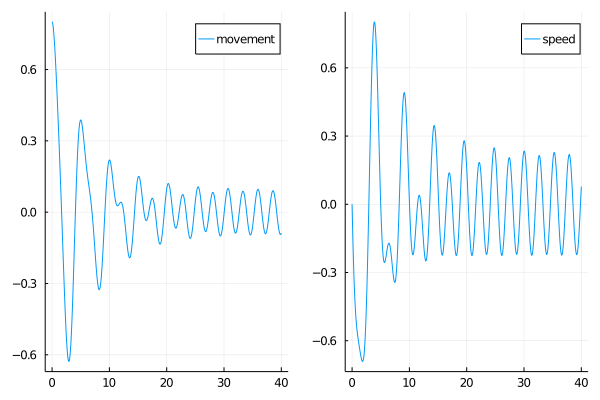

In [3]:
# File: /scripts/spring_std.jl
# -----------------------------------------------------------------------------------------

IArray = InternalArray


# 1. Solving the equation using the euler method ------------------------------------------

# We are asked to find solutions for the time interval [t0, t0+40].
# I want to execute the following with a step of 1e-3,
# so I'll set an appropiate number of iterations.
step = 1e-3
nit = Int(40/step)  # round to avoid small rounding errors

prob = SpringProblem(p0 = 0.8, v0 = 0, m = 1, k = 1.5, b = 0.3, A = 0.4, ω = 2.4)

x = eulermethod(prob, step, nit)

# 2. Plotting the result ------------------------------------------------------------------

timeline = [prob.t0 + i*step for i in 0:length(x)-1]
position = plot(timeline, IArray(x, 1), label = "movement")
speed = plot(timeline, IArray(x, 2), label = "speed")
plot(position, speed)

## Validating the solution

Unfortunately, we didn't have an analytical solution to estimate the error produced by our approximation to the previous problem.

What we could do, however, is to solve the problem analytically when there are no friction and external forces and compare it to the solution computed by our algorithm.

How to obtain the solution is well documented in [Wikipedia](https://en.wikipedia.org/wiki/Simple_harmonic_motion#Dynamics).

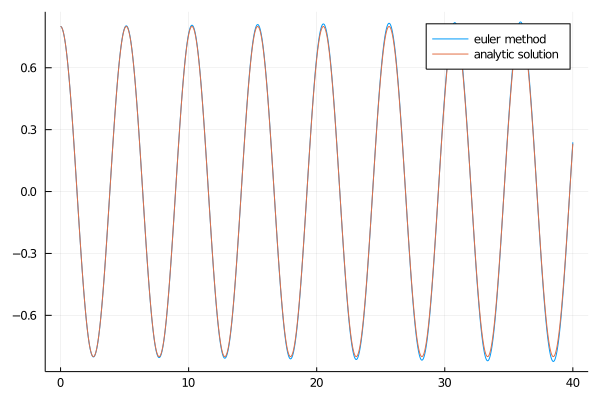

In [4]:
# File: /scripts/spring_validation.jl
# -----------------------------------------------------------------------------------------

IArray = InternalArray


# 3. Validating the solution --------------------------------------------------------------

step = 1e-3
nit = Int(40/step)  # round to avoid small rounding errors

# We define a problem with no friction
prob = SpringProblem(p0 = 0.8, v0 = 0, m = 1, k = 1.5)

x = eulermethod(prob, step, nit)

timeline = [prob.t0 + i*step for i in 0:length(x)-1]
plot(timeline, IArray(x, 1), label = "euler method")

# And also define the solution we would have obtained by analytic methods
# Reference: https://en.wikipedia.org/wiki/Simple_harmonic_motion
ω0 = sqrt(prob.k/prob.m)
g(t) = prob.p0*cos(ω0*t) + prob.v0/ω0*sin(ω0*t)

y = g.(timeline)
plot!(timeline, y, label = "analytic solution")

In [5]:
# File: /scripts/spring_validation.jl
# -----------------------------------------------------------------------------------------

# (The comparison in my computer is very close)
# (Which means that for the second step we could have taken a smaller L very likely)
# Let's check the norm of the difference:

err = maximum(norm.(y-IArray(x, 1)))

0.023428055330314446

## Choosing an appropiate step to obtain a final error smaller than 1e-2

We had seen in class a [theorem](https://en.wikipedia.org/wiki/Euler_method#Local_truncation_error) that states that, under some constraints, the accumulated error in the euler method is proportional to the step size. Even more, the constant is bounded by $\frac{hM}{2L}(e^{L(t-t_0)}-1)$, where $M$ is an upper bound for the second derivative of the solution (in the interval) and $L$ is the lipschitz constant of $f$ fixed the first variable.

Because

$f(t, (x, x')) - f(t, (y, y')) = $
$(x', -kx -b*x' + A*\sin(\omega t)) - (y, -ky -b*y' + A*\sin(\omega t)) = $
$(x'-y', -k(x-y) -b(x'-y'))$,

and

$|(x'-y', -k(x-y) -b(x'-y'))| \approx (k+b)|(x-y, x'-y')|$ (it's indeed a very nice assumption...),

I had taken $L$ as $k+b$.

To find $M$, I decided to approximate the value in the interval using the approximated solution. However, I made a mistake in my code during the exam and I found the maximum over the derivative instead.

In the end, the step that I calculated with my approach was too small. I don't think bounding the second derivative instead of the first would have made a big difference, because in the end, the oscillating nature of the speed means the acceleration is also oscillating and probably with a similar amplitude. And even if I were wrong, the major impact in the formula comes from $L$, that affects the exponent. Therefore, the professor recommended me during the exam to stick to comparison methods to obtain a good aproximation (again, using the solution to the frictionless problem).

In [6]:
# File: /scripts/spring_validation.jl
# -----------------------------------------------------------------------------------------

# <-- Copied from the definitions
n = 1
function f(t, x)
    p = x[1:n]
    v = x[n+1:2*n]
    return [v; (-prob.k*p -prob.b*v + [prob.A*sin(prob.ω*t)])/prob.m]
end

M = maximum((norm ∘ f).(timeline, x))
L = prob.k+prob.b
err_ct = M/L*(ℯ^(L*40)-1) # error constant
target_step = 10e-2/err_ct

# After checking that with 1e-3 the error is approximately $0.02$
# for the solution without friction.
# It seems natural to admit that an appropiate step to obtain
# an error less than 1e-2 is approximately 5e-4.
# This can be verified using this same script but
# with a smaller error for the method without friction.

# After doing it, I saw that it was not enough and
# the error was still slightly larger than 1e-2.
# With the step equal to 1e-4, the error for the problem without friction is $0.0023$.
# Hence, we can assume that it won't be much larger for the problem with friction.

1.0634284151262587e-27

## Measuring the frequency and perturbing the movement with a synchronized force

The last exercise was to find the frequency of the movement for the ideal motion (without friction nor external forces) and perturbating the system with a synchronized force.

Visually, we could see in the plot that the time elapsed before arriving at the same position was a bit bigger than $5$. My approach to find it was writing a loop that would scan the computed solution for the index of the first point close enough to the initial position. I had to skip some of the first points because they were very close to the initial point.

Because the step size was 1e-3, I conclude that the error can't be higher than $50 \cdot 1e-3$. Being $50$ the number of points I had skipped in the beginning to not accidentally pick a wrong point. Because the solution is periodical, this points ought to be at a similar distance to the first one to those close to the next crest.

In [7]:
# File: /scripts/spring_frequency_forced.jl
# -----------------------------------------------------------------------------------------

step = 1e-3
nit = Int(40/step)  # round to avoid small rounding errors

# We define a problem with no friction
prob = SpringProblem(p0 = 0.8, v0 = 0, m = 1, k = 1.5)

x = eulermethod(prob, step, nit)

timeline = [prob.t0 + i*step for i in 0:length(x)-1]
plot(timeline, IArray(x, 1), label = "standard")

# 5. Finding the frequency of the unforced movement ---------------------------------------

# Empirically, We can see in the plot that the distance between two
# equal values (!= 0) is aproximately 5.
# Let's get the actual distance from our solution.

p0 = 1       # Reference point
P0 = -1      # Next equal point
for i = 50:length(x) # We avoid the first numbers because they are very close
    if norm(x[p0][1]-x[i][1]) < 1e-3
        P0 = i
        break
    end
end

if P0 != -1
    period = timeline[P0]-timeline[p0] # Is similar to what we observed
    freq = 1/period
end

0.19805902158843333

The frequency of the movement is the inverse to the period previously computed. However, note that the parameter the problem needs is not the frequency but the angular velocity, which is $2\pi$ times the frequency.

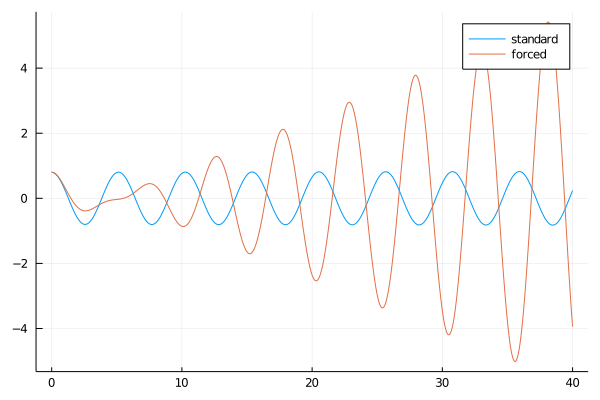

In [8]:
# File: /scripts/spring_frequency_forced.jl
# -----------------------------------------------------------------------------------------

# 6. Using this frequency to force it -----------------------------------------------------

cond_prob = SpringProblem(p0 = 0.8, v0 = 0, m = 1, k = 1.5, A = 0.4, ω = 2*π*freq)

y = eulermethod(cond_prob, step, nit)
plot!(timeline, IArray(y, 1), label = "forced")

In the end I plotted the comparion of the original solution and that perturbed by a synchronized force. It allows us to see that the amplitude of the movement keeps growing and growing.

The explanation to this is simple. Once the force is aligned in time with the movement, it can help each cycle get a bit further (if the force was suddenly removed, then the iterations would maintain their amplitude because the spring force is conservative). But, why would the force be aligned with the movement? After all, we can see that in the beginning the force goes against the movement of the mass. The reason is that this is a dynamical systems that tends to align. If the force is stopping the movement, then it will make the mass return to the starting position later, until the mass movement is align